In [ ]:
!pip install "numpy<2"

# Ahora instalar las demás librerías
!pip install pandas matplotlib seaborn scikit-learn scikit-surprise networkx

import warnings
warnings.filterwarnings('ignore')

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2544623 sha256=f551f7f38c2dfcd3ae1cf96a8498690c2a66e9a63c466aa1116b66eeaf1ab140
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_split
import random

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Last.FM

Este dataset contiene información de redes sociales, etiquetado (*tagging*) e historial de escucha de artistas musicales de 2.000 usuarios del sistema de música en línea Last.fm.

Consta de los siguientes archivos de datos disponibles. El formato de los datos es una entrada por línea, separados por tabuladores ("\t"):

### Resumen de Archivos y Campos

| Archivo | Contenido | Campos (Formato de Datos) |
| :--- | :--- | :--- |
| **`artists.dat`** | Contiene información sobre los artistas musicales escuchados y etiquetados por los usuarios. | **`id` \t `name` \t `url` \t `pictureURL`** |
| **`tags.dat`** | Contiene el conjunto de etiquetas (*tags*) disponibles en el conjunto de datos. | **`tagID` \t `tagValue`** |
| **`user_artists.dat`** | Contiene los artistas escuchados por cada usuario, e incluye una cuenta de escucha (*listening count*) para cada par `[user, artist]`. | **`userID` \t `artistID` \t `weight`** |
| **`user_taggedartists.dat`** | Contiene las asignaciones de etiquetas (*tag assignments*) de artistas proporcionadas por cada usuario particular. | **`userID` \t `artistID` \t `tagID` \t `day` \t `month` \t `year`** |
| **`user_taggedartists-timestamps.dat`** | Contiene las asignaciones de etiquetas, incluyendo las marcas de tiempo (*timestamps*) en las que se realizaron. | **`userID` \t `artistID` \t `tagID` \t `timestamp`** |
| **`user_friends.dat`** | Contiene las relaciones de amistad entre usuarios en la base de datos. | **`userID` \t `friendID`** |

**Estadísticas clave del conjunto de datos:**
El conjunto de datos **hetrec2011-lastfm-2k** incluye 1892 usuarios y 17632 artistas. Hay 12717 relaciones de amistad bidireccionales entre usuarios, y 92834 relaciones de artistas escuchados por los usuarios (tuplas `[user, artist, listeningCount]`). En total, hay 11946 etiquetas y 186479 asignaciones de etiquetas (tuplas `[user, tag, artist]`).

In [ ]:
# Cargar todos los archivos del dataset HetRec Last.fm
print(" Cargando dataset HetRec 2011 Last.fm...")

# Artistas
artists = pd.read_csv('artists.dat', sep='\t', encoding='latin-1')

# Interacciones usuario-artista (el núcleo de nuestro modelo)
user_artists = pd.read_csv('user_artists.dat', sep='\t', encoding='latin-1')

# Tags disponibles
tags = pd.read_csv('tags.dat', sep='\t', encoding='latin-1')

# Tags asignados por usuarios a artistas
user_tagged = pd.read_csv('user_taggedartists.dat', sep='\t', encoding='latin-1')

# Red social de amigos
user_friends = pd.read_csv('user_friends.dat', sep='\t', encoding='latin-1')

# Convertir columnas a tipos numéricos apropiados
user_artists['userID'] = pd.to_numeric(user_artists['userID'], errors='coerce')
user_artists['artistID'] = pd.to_numeric(user_artists['artistID'], errors='coerce')
user_artists['weight'] = pd.to_numeric(user_artists['weight'], errors='coerce')

artists['id'] = pd.to_numeric(artists['id'], errors='coerce')

user_friends['userID'] = pd.to_numeric(user_friends['userID'], errors='coerce')
user_friends['friendID'] = pd.to_numeric(user_friends['friendID'], errors='coerce')

user_tagged['userID'] = pd.to_numeric(user_tagged['userID'], errors='coerce')
user_tagged['artistID'] = pd.to_numeric(user_tagged['artistID'], errors='coerce')
user_tagged['tagID'] = pd.to_numeric(user_tagged['tagID'], errors='coerce')

tags['tagID'] = pd.to_numeric(tags['tagID'], errors='coerce')

# Eliminar filas con valores nulos que puedan haber resultado de la conversión
user_artists = user_artists.dropna()
user_friends = user_friends.dropna()
user_tagged = user_tagged.dropna()

print(" Datos cargados exitosamente!")
print(f" Estadísticas del dataset:")
print(f"   - Usuarios únicos: {user_artists['userID'].nunique():,}")
print(f"   - Artistas únicos: {user_artists['artistID'].nunique():,}")
print(f"   - Interacciones: {len(user_artists):,}")
print(f"   - Tags únicos: {len(tags):,}")
print(f"   - Relaciones de amistad: {len(user_friends):,}")

# Verificar que los datos se cargaron correctamente
print("\n Verificación de tipos de datos:")
print("user_artists:")
print(user_artists.dtypes)
print("\nPrimeras filas de user_artists:")
print(user_artists.head())

 Cargando dataset HetRec 2011 Last.fm...
 Datos cargados exitosamente!
 Estadísticas del dataset:
   - Usuarios únicos: 1,892
   - Artistas únicos: 17,632
   - Interacciones: 92,834
   - Tags únicos: 11,946
   - Relaciones de amistad: 25,434

 Verificación de tipos de datos:
user_artists:
userID      int64
artistID    int64
weight      int64
dtype: object

Primeras filas de user_artists:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983


In [ ]:
artists = artists.rename(columns={'id': 'artistID'})

Tipo de user_counts: <class 'pandas.core.series.Series'>
Primeros valores: userID
757     480039
2000    468409
1418    416349
1642    388251
1094    379125
Name: weight, dtype: int64


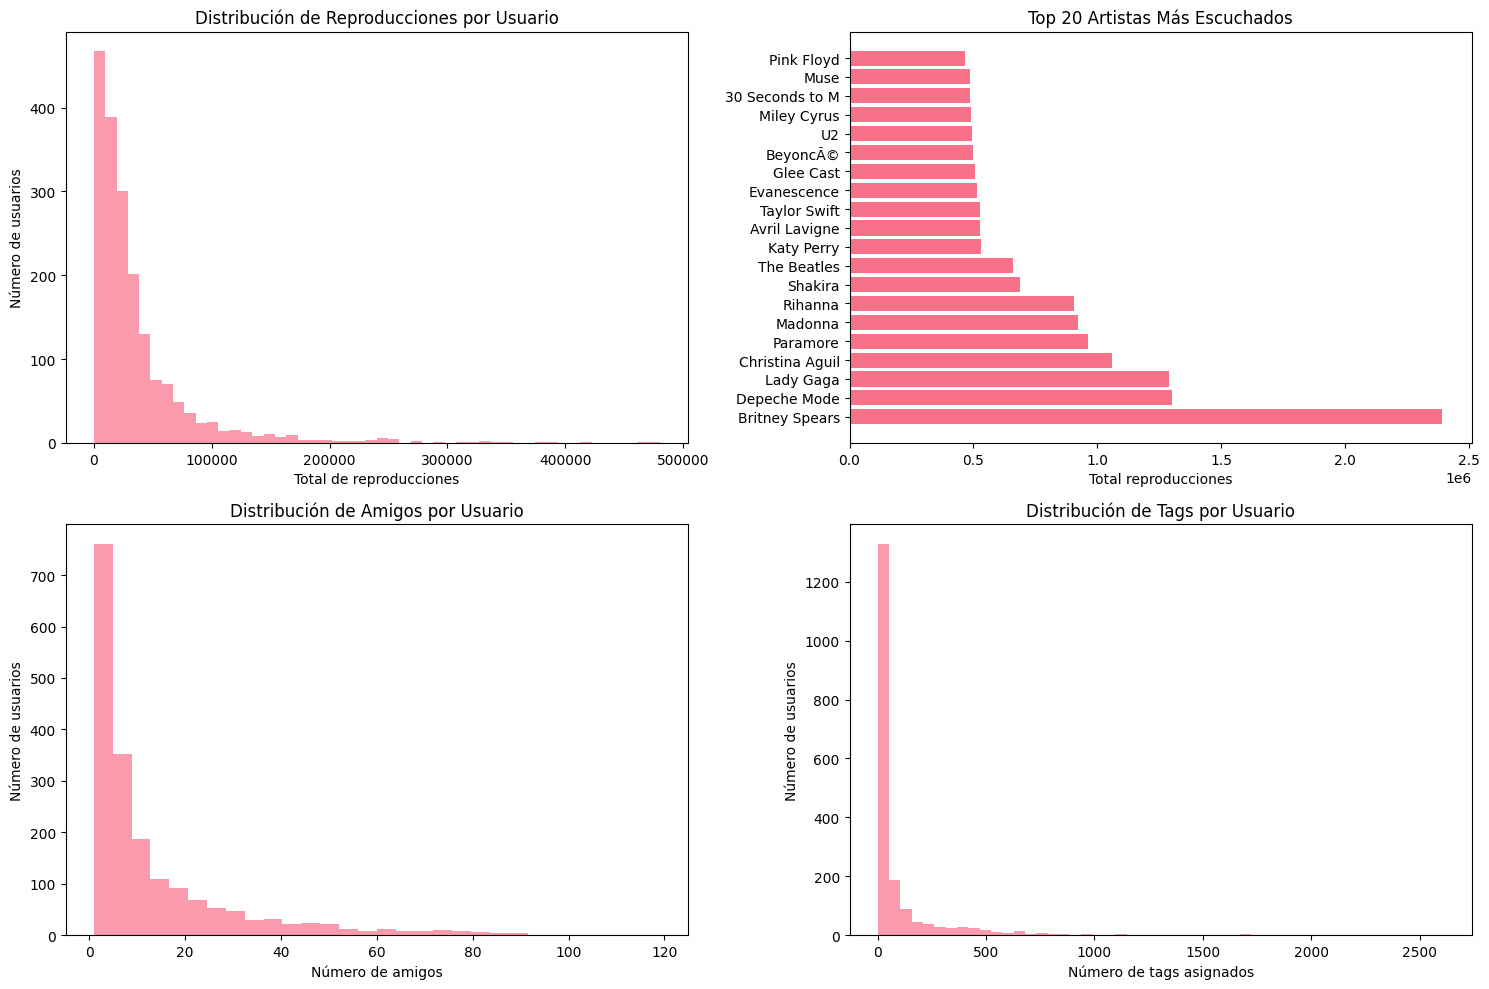


 Insights iniciales:
   - Usuario más activo: 480,039 reproducciones
   - Usuario promedio: 36566.6 reproducciones
   - Usuarios con amigos: 1,892 de 1,892
   - Usuarios que etiquetan: 1,892 de 1,892


In [ ]:
# Exploración de la distribución de datos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribución de reproducciones por usuario
user_counts = user_artists.groupby('userID')['weight'].sum().sort_values(ascending=False)

# Debug: verificar qué contiene user_counts
print("Tipo de user_counts:", type(user_counts))
print("Primeros valores:", user_counts.head())

axes[0,0].hist(user_counts.values, bins=50, alpha=0.7)  # Usar .values
axes[0,0].set_title('Distribución de Reproducciones por Usuario')
axes[0,0].set_xlabel('Total de reproducciones')
axes[0,0].set_ylabel('Número de usuarios')

# Top 20 artistas más escuchados
top_artists = user_artists.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(20)
artist_names = []
for aid in top_artists.index:
    name = artists[artists['artistID'] == aid]['name'].iloc[0] if len(artists[artists['artistID'] == aid]) > 0 else f"Artist_{aid}"
    artist_names.append(name[:15])

axes[0,1].barh(range(len(top_artists)), top_artists.values)
axes[0,1].set_yticks(range(len(top_artists)))
axes[0,1].set_yticklabels(artist_names)
axes[0,1].set_title('Top 20 Artistas Más Escuchados')
axes[0,1].set_xlabel('Total reproducciones')

# Distribución de amigos por usuario
friends_per_user = user_friends.groupby('userID').size()
axes[1,0].hist(friends_per_user.values, bins=30, alpha=0.7)
axes[1,0].set_title('Distribución de Amigos por Usuario')
axes[1,0].set_xlabel('Número de amigos')
axes[1,0].set_ylabel('Número de usuarios')

# Distribución de tags por usuario
tags_per_user = user_tagged.groupby('userID').size()
axes[1,1].hist(tags_per_user.values, bins=50, alpha=0.7)
axes[1,1].set_title('Distribución de Tags por Usuario')
axes[1,1].set_xlabel('Número de tags asignados')
axes[1,1].set_ylabel('Número de usuarios')

plt.tight_layout()
plt.show()

print(f"\n Insights iniciales:")
print(f"   - Usuario más activo: {int(user_counts.values.max()):,} reproducciones")
print(f"   - Usuario promedio: {float(user_counts.values.mean()):.1f} reproducciones")
print(f"   - Usuarios con amigos: {len(friends_per_user):,} de {user_artists['userID'].nunique():,}")
print(f"   - Usuarios que etiquetan: {len(tags_per_user):,} de {user_artists['userID'].nunique():,}")

In [ ]:
# Análisis de densidad de la matriz usuario-artista
n_users = user_artists['userID'].nunique()
n_artists = user_artists['artistID'].nunique()
n_interactions = len(user_artists)

sparsity = 1 - (n_interactions / (n_users * n_artists))

print(f" Análisis de Sparsity:")
print(f"   - Matriz: {n_users:,} usuarios × {n_artists:,} artistas")
print(f"   - Interacciones observadas: {n_interactions:,}")
print(f"   - Sparsity: {sparsity:.4f} ({sparsity*100:.2f}% vacío)")
print(f"   - Esto es típico en sistemas de recomendación reales!")

# Visualización de sparsity por segmentos de usuarios
user_activity = user_artists.groupby('userID').size().sort_values(ascending=False)
segments = {
    'Muy Activos (Top 10%)': user_activity.head(int(0.1 * len(user_activity))),
    'Activos (10-30%)': user_activity.iloc[int(0.1 * len(user_activity)):int(0.3 * len(user_activity))],
    'Promedio (30-70%)': user_activity.iloc[int(0.3 * len(user_activity)):int(0.7 * len(user_activity))],
    'Pasivos (70-100%)': user_activity.tail(int(0.3 * len(user_activity)))
}

for segment_name, segment_data in segments.items():
    avg_interactions = segment_data.mean()
    print(f"   - {segment_name}: {avg_interactions:.1f} artistas promedio")

 Análisis de Sparsity:
   - Matriz: 1,892 usuarios × 17,632 artistas
   - Interacciones observadas: 92,834
   - Sparsity: 0.9972 (99.72% vacío)
   - Esto es típico en sistemas de recomendación reales!
   - Muy Activos (Top 10%): 50.0 artistas promedio
   - Activos (10-30%): 50.0 artistas promedio
   - Promedio (30-70%): 50.0 artistas promedio
   - Pasivos (70-100%): 46.9 artistas promedio


In [ ]:
# Preparación de datos para modelo colaborativo tradicional
print(" Preparando datos para modelo colaborativo tradicional...")

# IMPORTANTE: Solo usamos user_artists.dat (ignoramos social, tags, temporal)
print("  ENFOQUE TRADICIONAL: Solo usamos historial de reproducciones")
print("   - Ignoramos red social (user_friends.dat)")
print("   - Ignoramos tags semánticos (user_taggedartists.dat)")
print("   - Ignoramos información temporal")

# Crear matriz usuario-artista
def create_user_item_matrix(df):
    """Crear matriz usuario-artista para collaborative filtering"""
    user_ids = sorted(df['userID'].unique())
    artist_ids = sorted(df['artistID'].unique())

    # Mapeo de IDs a índices
    user_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
    artist_to_idx = {aid: idx for idx, aid in enumerate(artist_ids)}

    # Crear matriz sparse
    rows, cols, data = [], [], []
    for _, row in df.iterrows():
        user_idx = user_to_idx[row['userID']]
        artist_idx = artist_to_idx[row['artistID']]
        rows.append(user_idx)
        cols.append(artist_idx)
        data.append(row['weight'])

    matrix = csr_matrix((data, (rows, cols)),
                       shape=(len(user_ids), len(artist_ids)))

    return matrix, user_to_idx, artist_to_idx, user_ids, artist_ids

# Crear la matriz
user_item_matrix, user_to_idx, artist_to_idx, user_ids, artist_ids = create_user_item_matrix(user_artists)

print(f" Matriz creada: {user_item_matrix.shape}")
print(f"   - Densidad: {user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.4f}")

 Preparando datos para modelo colaborativo tradicional...
  ENFOQUE TRADICIONAL: Solo usamos historial de reproducciones
   - Ignoramos red social (user_friends.dat)
   - Ignoramos tags semánticos (user_taggedartists.dat)
   - Ignoramos información temporal
 Matriz creada: (1892, 17632)
   - Densidad: 0.0028


In [ ]:
# Modelo 1: Matrix Factorization con SVD
print(" Implementando Matrix Factorization (SVD)...")

# Normalizar la matriz (log transform para manejar skewness)
user_item_dense = user_item_matrix.toarray()
user_item_log = np.log1p(user_item_dense)  # log(1 + x) para evitar log(0)

# SVD Truncado
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
user_factors = svd.fit_transform(user_item_log)
artist_factors = svd.components_.T

print(f" SVD completado:")
print(f"   - Componentes latentes: {n_components}")
print(f"   - Varianza explicada: {svd.explained_variance_ratio_.sum():.3f}")

# Función para generar recomendaciones
def get_recommendations(user_id, user_factors, artist_factors, user_to_idx, artist_ids,
                       user_item_matrix, top_k=10):
    """Generar recomendaciones para un usuario"""
    if user_id not in user_to_idx:
        return [], "Usuario no encontrado"

    user_idx = user_to_idx[user_id]
    user_vector = user_factors[user_idx]

    # Calcular scores para todos los artistas
    scores = np.dot(user_vector, artist_factors.T)

    # Obtener artistas ya escuchados
    listened_artists = set(user_item_matrix[user_idx].nonzero()[1])

    # Filtrar artistas ya escuchados y obtener top-k
    recommendations = []
    for artist_idx in np.argsort(scores)[::-1]:
        if artist_idx not in listened_artists:
            artist_id = artist_ids[artist_idx]
            artist_name = artists[artists['artistID'] == artist_id]['name'].iloc[0] if len(artists[artists['artistID'] == artist_id]) > 0 else f"Artist_{artist_id}"
            recommendations.append((artist_id, artist_name, scores[artist_idx]))
            if len(recommendations) >= top_k:
                break

    return recommendations, "OK"

# Probar con un usuario ejemplo
test_user = user_ids[0]
recs, status = get_recommendations(test_user, user_factors, artist_factors,
                                 user_to_idx, artist_ids, user_item_matrix)

print(f"\n Recomendaciones para Usuario {test_user}:")
for i, (aid, name, score) in enumerate(recs):
    print(f"   {i+1}. {name} (score: {score:.3f})")

 Implementando Matrix Factorization (SVD)...
 SVD completado:
   - Componentes latentes: 50
   - Varianza explicada: 0.288

 Recomendaciones para Usuario 2:
   1. Pet Shop Boys (score: 5.277)
   2. a-ha (score: 3.972)
   3. Massive Attack (score: 3.739)
   4. Erasure (score: 3.124)
   5. BjÃ¶rk (score: 2.770)
   6. The Human League (score: 2.668)
   7. Kings of Leon (score: 2.663)
   8. The Prodigy (score: 2.535)
   9. Simple Minds (score: 2.489)
   10. Orchestral Manoeuvres in the Dark (score: 2.483)
